# Data Wrangling with Spark

## Data Wrangling User Logs

This first section imports libraries, instantiates a `SparkSession`, and then reads in the data set

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/10 13:32:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
path = "../data/sparkify_log_small.json"
user_log_df = spark.read.json(path)

### Data Exploration

Explore the data by inspecting the first 5 rows in the DataFrame with the `.take()` function

In [5]:
# Explore the Dataset
# View 5 records 

print(
    user_log_df.take(5)
)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'), Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'), Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstName

Print the schema with `.printSchema()`

Which displays the schema including column names and data types:

In [6]:
# Print the schema

user_log_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Display a DataFrame in a table format with the `.show()` function

In [7]:
# Describe the dataframe

user_log_df.describe().show()

23/07/10 13:40:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

Use the `.describe()` function with the `.show()` function to explore basic statistics about the data.

In [10]:
# Describe the statistics for the song length column

user_log_df.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|             8347|
|   mean|249.6486587492506|
| stddev|95.00437130781461|
|    min|          1.12281|
|    max|        1806.8371|
+-------+-----------------+



In [11]:
# Count the rows in the dataframe

print(
    user_log_df.count()
)

10000


Use `.dropDuplicates()` to see each kind of page once, and sort by page

In [12]:
# Select the page column, drop the duplicates, and sort by page
# We want to distinct the list of all pages, and then sort them by page name

user_log_df.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



Select data for all pages where `userId` is `1046`

In [13]:
# Select data for all pages where userId is 1046
# And selecting specific columns that we're interested in

user_log_df.select(["userId", "firstname", "page", "song"]) \
    .where(user_log_df.userId == "1046") \
    .show()

+------+---------+--------+--------------------+
|userId|firstname|    page|                song|
+------+---------+--------+--------------------+
|  1046|  Kenneth|NextSong|Christmas Tears W...|
|  1046|  Kenneth|NextSong|  Be Wary Of A Woman|
|  1046|  Kenneth|NextSong|   Public Enemy No.1|
|  1046|  Kenneth|NextSong|Reign Of The Tyrants|
|  1046|  Kenneth|NextSong|      Father And Son|
|  1046|  Kenneth|NextSong|               No. 5|
|  1046|  Kenneth|NextSong|           Seventeen|
|  1046|  Kenneth|    Home|                null|
|  1046|  Kenneth|NextSong|          War on war|
|  1046|  Kenneth|NextSong|   Killermont Street|
|  1046|  Kenneth|NextSong|        Black & Blue|
|  1046|  Kenneth|  Logout|                null|
|  1046|  Kenneth|    Home|                null|
|  1046|  Kenneth|NextSong|     Heads Will Roll|
|  1046|  Kenneth|NextSong|Bleed It Out [Liv...|
|  1046|  Kenneth|NextSong|              Clocks|
|  1046|  Kenneth|NextSong|           Love Rain|
|  1046|  Kenneth|Ne

### Calculating Statistics by Hour

Display the results in a scatter plot

In [14]:
# Do a user defined function (udf) in PySpark to extract the hour from the timestamp
# We're converting that x which is a timestamp into an hour 

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [15]:
# call the udf function on the timestamp column and create a new column called hour
# pass in the get_hour udf function and pass in the timestamp column (as input) that comes from the user_log_df dataframe

user_log_df = user_log_df.withColumn("hour", get_hour(user_log_df.ts))

In [16]:
print(
    # Get the first row
    user_log_df.head(1)
)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='6')]


#### Select just the NextSong page

In [17]:
# we're filtering by that page where users went to the next song

songs_in_hour_df = user_log_df.filter(user_log_df.page == "NextSong") \
    .groupby(user_log_df.hour) \
    .count() \
    .orderBy(user_log_df.hour.cast("float"))

# show that dataframe that pertains to the next song (the number of songs played in each hour)
songs_in_hour_df.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  484|
|   1|  430|
|   2|  362|
|   3|  295|
|   4|  257|
|   5|  248|
|   6|  369|
|   7|  375|
|   8|  456|
|   9|  454|
|  10|  382|
|  11|  302|
|  12|  352|
|  13|  276|
|  14|  348|
|  15|  358|
|  16|  375|
|  17|  249|
|  18|  216|
|  19|  228|
+----+-----+
only showing top 20 rows



In [18]:
# convert that to a Pandas dataframe
# use the `to_numeric` on Pandas to convert the hour column to a numeric 

songs_in_hour_pd = songs_in_hour_df.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

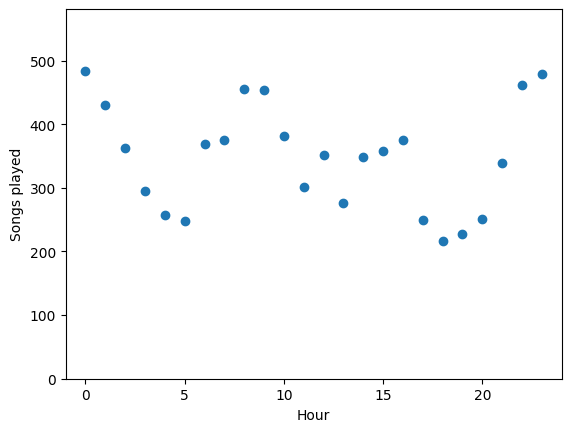

In [19]:
# using Plotly to plot the number of songs played in each hour
# it's going to create a scatter plot diagram with the hour on the x-axis and the number of songs played on the y-axis

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.show()

### Drop Rows with Missing Values

As you'll see, there are no missing values in the `userID` or `session` columns. But there are userID values that are empty strings.

In [20]:
# As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.
# how = 'any' or 'all'. If 'any', drop a row if it contains any nulls. If 'all', drop a row only if all its values are null.
# subset = list of columns to consider

user_log_valid_df = user_log_df.dropna(how = "any", subset = ["userId", "sessionId"])

In [21]:
# How many are there now that we dropped rows with null userId or sessionId?

print(
    user_log_valid_df.count()
)

10000


In [22]:
# select all unique user ids into a dataframe

user_log_df.select("userId") \
    .dropDuplicates() \
    .sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [23]:
# Select only data for where the userId column isn't an empty string (different from null)

user_log_valid_df = user_log_valid_df.filter(user_log_valid_df["userId"] != "")

In [24]:
# Notice the count has dropped after dropping rows with empty userId

print(
    user_log_valid_df.count()
)

9664


## Users Downgrade Their Accounts

In [25]:
# Find when users downgrade their accounts and then show those log entries. 

user_log_valid_df.filter("page = 'Submit Downgrade'") \
    .show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  19|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [26]:
user_log_df.select(["userId", "firstname", "page", "level", "song"]) \
    .where(user_log_df.userId == "1138") \
    .show()

+------+---------+--------+-----+--------------------+
|userId|firstname|    page|level|                song|
+------+---------+--------+-----+--------------------+
|  1138|    Kelly|    Home| paid|                null|
|  1138|    Kelly|NextSong| paid| Everybody Everybody|
|  1138|    Kelly|NextSong| paid|               Gears|
|  1138|    Kelly|NextSong| paid|        Use Somebody|
|  1138|    Kelly|NextSong| paid|Love Of My Life (...|
|  1138|    Kelly|NextSong| paid|Down In The Valle...|
|  1138|    Kelly|NextSong| paid|Treat Her Like A ...|
|  1138|    Kelly|NextSong| paid|Everybody Thinks ...|
|  1138|    Kelly|NextSong| paid|      Fourteen Wives|
|  1138|    Kelly|NextSong| paid|   Love On The Rocks|
|  1138|    Kelly|NextSong| paid|           Breakeven|
|  1138|    Kelly|NextSong| paid|          Leaf House|
|  1138|    Kelly|NextSong| paid|       NAISEN KANSSA|
|  1138|    Kelly|NextSong| paid|  You're In My Heart|
|  1138|    Kelly|NextSong| paid|Roll On Down The ...|
|  1138|  

In [27]:
# Create a user defined function to return a 1 if the record contains a downgrade

flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [28]:
# Select data including the user defined function

user_log_valid_df = user_log_valid_df \
    .withColumn("downgraded", flag_downgrade_event("page"))

print(
    user_log_valid_df.head()
)

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='6', downgraded=0)


### Partition by user id

In [29]:
from pyspark.sql import Window

In [30]:
# Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

windowval = Window.partitionBy("userId") \
    .orderBy(desc("ts")) \
    .rangeBetween(Window.unboundedPreceding, 0)

In [31]:
# Fsum is a cumulative sum over a window - in this case a window showing all events for a user
# Add a column called phase, 0 if the user hasn't downgraded yet, 1 if they have

user_log_valid_df = user_log_valid_df \
    .withColumn("phase", Fsum("downgraded") \
    .over(windowval))

user_log_valid_df.show()    


+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------+-----+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|downgraded|phase|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------+-----+
|  The Get Up Kids|Logged In| Veronica|     F|            0| Buckley|178.59873| free|Detroit-Warren-De...|   PUT|NextSong|1512966806284|     6676|             Overdue|   200|1513828388284|"Mozilla/5.0 (Mac...|    10|  11|         0|    0|
|      OneRepublic|Logged In| Veronica|     

In [32]:
# Show the phases for user 1138 

user_log_valid_df \
    .select(["userId", "firstname", "ts", "page", "level", "phase"]) \
    .where(user_log_df.userId == "1138") \
    .sort("ts") \
    .show()

+------+---------+-------------+--------+-----+-----+
|userId|firstname|           ts|    page|level|phase|
+------+---------+-------------+--------+-----+-----+
|  1138|    Kelly|1513729066284|    Home| paid|    1|
|  1138|    Kelly|1513729066284|NextSong| paid|    1|
|  1138|    Kelly|1513729313284|NextSong| paid|    1|
|  1138|    Kelly|1513729552284|NextSong| paid|    1|
|  1138|    Kelly|1513729783284|NextSong| paid|    1|
|  1138|    Kelly|1513730001284|NextSong| paid|    1|
|  1138|    Kelly|1513730263284|NextSong| paid|    1|
|  1138|    Kelly|1513730518284|NextSong| paid|    1|
|  1138|    Kelly|1513730768284|NextSong| paid|    1|
|  1138|    Kelly|1513731182284|NextSong| paid|    1|
|  1138|    Kelly|1513731435284|NextSong| paid|    1|
|  1138|    Kelly|1513731695284|NextSong| paid|    1|
|  1138|    Kelly|1513731857284|NextSong| paid|    1|
|  1138|    Kelly|1513732160284|NextSong| paid|    1|
|  1138|    Kelly|1513732302284|NextSong| paid|    1|
|  1138|    Kelly|1513732540